In [113]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [114]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output


In [115]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files ../.

In [116]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat* ../bar_files/.

In [117]:
# This function works with both dbtable and the catalog header name on EDD
def get_catal(catal_string, infoFile="../bar_files/catalogs_info.dat", bars_folder='../bar_files/'):
    
    xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.", verbose=True)

    with open(infoFile, "r") as f:
        lines = f.readlines()


        try:
            for i, line in enumerate(lines):
                if catal_string in line:
                    
                    while not "begin" in line:
                        i-=1
                        line = lines[i]
                    while not "filename" in line: 
                    break
        except: 
            return "", []
            
        catal_columns = []
        
        try:
            while not "column" in line:
                i+=1
                line=lines[i]
            while not 'end' in line:
                catal_columns.append(line.split("=>")[1].split("|")[0].strip())
                i+=1
                line=lines[i]
                
        except:
            print("why")
            return "", []


    catal_file_name = fname_string.split("=>")[1].strip("\n").strip("")
    
    xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/"+catal_file_name+"  "+bars_folder+"/.", verbose=True)
    
    data = pd.read_csv(bars_folder+catal_file_name, names=catal_columns, delimiter='|')
    
    for col in catal_columns:
        if col.upper()=="PGC":
            break
    
    data.rename(columns={col:col.upper()}, inplace=True)
    data = data.set_index('PGC')
    
    # taking care of empty string
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if "1PGC" in data.columns:
        data = data.rename(columns={"1PGC": "PGC1"})
    else:
        data["PGC1"] = data.index.values
    
    if "av_flag" in data.columns:
        data = data[data.av_flag==0]
    
    
    return data

In [118]:
def make_data(data, catalogs, catal_data, catal_key, catal_DM="DM", catal_eDM="eDM", delta=0):
    
    if not catal_key in catalogs and not catal_key in data:
        data[catal_key] = catal_data[["PGC1", catal_DM, catal_eDM]]
        data[catal_key] = data[catal_key].rename(columns={"PGC1": "PGC1_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_DM: "DM_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_eDM: "eDM_"+catal_key})
        
        catalogs.append(catal_key)
        
        data[catal_key]["DM_"+catal_key] += delta
        
    else:
        print("This catalog has been already imported ...")
        print("Use a different key than "+catal_key)
    
    return data, catalogs
    

In [119]:
data = {}
catalogs = []

In [120]:
catal_dbtable = "CF4 All Calibrators"
catal = get_catal(catal_dbtable)

catal['w_'] = 1./catal['eDM']**2
catal['xw_'] = (catal['DM'])*catal['w_']

dg = catal.groupby("PGC1").agg(["sum", "count"])


dg['eDMg_'] = np.sqrt(1./dg['w_']['sum'])
dg['DMg_'] = (dg['xw_']['sum'])/dg['w_']['sum']

ss = ['DMg_','eDMg_']
dg_ = dg[ss]

dg = dg_.reset_index().rename(columns={"PGC1":"PGC"}).set_index("PGC")


scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/3ZPcat_bar  ../bar_files//.


In [121]:
catal_dbtable = "CF4 All Calibrator Groups"
catal = get_catal(catal_dbtable)
catal = catal[catal.DM>30.4]

catal = catal.join(dg)
catal["eDMg"] = catal[catal.columns[-1]]
catal["DMg"] = catal[catal.columns[-3]]

data, catalogs = make_data(data, catalogs, catal, "Calib_Grp", catal_DM="DMg", catal_eDM="eDMg")

catal.head()


scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/3ZPcalib_groups_bar  ../bar_files//.


,N,DM,rms,StDv,PGC1,"(DMg_, )","(eDMg_, )",eDMg,DMg
PGC,,,,,,,,,
218,1,30.730,NaN,NaN,218,30.730,0.100,0.100,30.730
1583,1,34.527,NaN,NaN,1583,34.527,0.250,0.250,34.527
6848,1,32.830,NaN,NaN,6848,32.830,0.109,0.109,32.830
9776,1,33.709,NaN,NaN,9776,33.709,0.149,0.149,33.709
9988,1,32.563,NaN,NaN,9988,32.563,0.074,0.074,32.563


In [122]:
catal_dbtable = "kcf4allgroup"
catal = get_catal(catal_dbtable)

data, catalogs = make_data(data, catalogs, catal, "All_Grp", catal_DM="DM_av", catal_eDM="eDM_av")

catal.head()


scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/allcf4_group_bar  ../bar_files//.


,DM_av,eDM_av,Vcmb,RA,DE,GLong,GLat,SGL,SGB,DM_SNIa,...,eDM_FP,DM_TFR,eDM_TFR,DM_SBFm,eDM_SBFm,DM_SBFir,eDM_SBFir,DM_SNII,eDM_SNII,PGC1
PGC,,,,,,,,,,,,,,,,,,,,,
12,35.142,0.41,6179,0.0360,-6.3739,90.1922,-65.9300,286.4249,11.3510,NaN,...,NaN,34.970,0.410,NaN,NaN,NaN,NaN,NaN,NaN,12
14,36.242,0.38,11474,359.9805,8.1846,101.6600,-52.5465,300.8070,15.3909,NaN,...,NaN,36.070,0.380,NaN,NaN,NaN,NaN,NaN,NaN,14
16,34.802,0.45,5354,0.0470,-5.1587,91.6006,-64.8655,287.6120,11.7030,NaN,...,NaN,34.630,0.450,NaN,NaN,NaN,NaN,NaN,NaN,16
55,34.392,0.39,4466,0.1558,33.6010,110.9495,-28.0857,327.0996,19.7763,NaN,...,NaN,34.220,0.390,NaN,NaN,NaN,NaN,NaN,NaN,55
63,35.392,0.41,8404,359.9938,28.2883,109.3762,-33.2252,321.4869,19.2652,NaN,...,NaN,35.220,0.410,NaN,NaN,NaN,NaN,NaN,NaN,63


In [123]:
catalogs

['Calib_Grp', 'All_Grp']

In [124]:
df = data["Calib_Grp"]

In [125]:
for cat in catalogs[1:]:
    df = df.join(data[cat], how='inner')

In [126]:
df = df[df.DM_Calib_Grp>30.4]
df = df[df.DM_All_Grp>30.4]

In [127]:
try: 
    df = df.drop(13418)
except:
    pass
try:
    df = df.drop(41220)
except:
    pass

In [128]:
len(df)

48

In [129]:
ss = []
for cat in catalogs[1:]:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]

In [130]:
df

,PGC1_Calib_Grp,DM_Calib_Grp,eDM_Calib_Grp,PGC1_All_Grp,DM_All_Grp,eDM_All_Grp,pgc1
PGC,,,,,,,
218,218,30.730000,0.100000,218,30.652,0.132,218.0
1583,1583,34.527000,0.250000,1583,34.240,0.090,1583.0
6848,6848,32.830000,0.109000,6848,32.937,0.150,6848.0
9776,9776,33.709000,0.149000,9776,33.469,0.120,9776.0
9988,9988,32.563000,0.074000,9988,32.720,0.150,9988.0
12626,12626,32.541000,0.059000,12626,32.500,0.144,12626.0
12651,12651,31.350000,0.100000,12651,31.641,0.044,12651.0
13602,13602,31.669000,0.050000,13602,31.872,0.400,13602.0
13727,13727,31.309000,0.037000,13727,31.378,0.096,13727.0


In [131]:
len(df)

48

In [132]:
ref = "Calib_Grp"
for col in catalogs:
    if col!=ref:
        df0 = df[["DM_"+ref, "DM_"+col]].dropna()

        delta = df0["DM_"+ref] - df0["DM_"+col]

        print(col, np.mean(delta), np.std(delta), len(delta))

All_Grp -0.004485848067200242 0.19910716857912822 48


In [133]:
df.head()

,PGC1_Calib_Grp,DM_Calib_Grp,eDM_Calib_Grp,PGC1_All_Grp,DM_All_Grp,eDM_All_Grp,pgc1
PGC,,,,,,,
218,218,30.730,0.100,218,30.652,0.132,218.0
1583,1583,34.527,0.250,1583,34.240,0.090,1583.0
6848,6848,32.830,0.109,6848,32.937,0.150,6848.0
9776,9776,33.709,0.149,9776,33.469,0.120,9776.0
9988,9988,32.563,0.074,9988,32.720,0.150,9988.0


In [134]:
len(df)

48

In [135]:
df['pgc1'] = df.index.values


d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

In [136]:
catalogs

['Calib_Grp', 'All_Grp']

In [137]:
def GfastChi2(dg, theta=None):
    
    d = theta[1]
    
    myDict = {}
    for cat in catalogs[1:]:
        myDict[cat] = d
    
    myDict[catalogs[0]] = 0   # zp

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [138]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=[0,1]))
###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

1484.7190622367239
Execution time:
0:00:00.015463


In [139]:
dg.head()

,N_Calib_Grp,DMg_Calib_Grp,eDMg_Calib_Grp,N_All_Grp,DMg_All_Grp,eDMg_All_Grp
,,,,,,
pgc1,,,,,,
218,1,30.730,0.100,1,30.652,0.132
1583,1,34.527,0.250,1,34.240,0.090
6848,1,32.830,0.109,1,32.937,0.150
9776,1,33.709,0.149,1,33.469,0.120
9988,1,32.563,0.074,1,32.720,0.150


In [140]:
df.head()

,PGC1_Calib_Grp,DM_Calib_Grp,eDM_Calib_Grp,PGC1_All_Grp,DM_All_Grp,eDM_All_Grp,pgc1,w_Calib_Grp,xw_Calib_Grp,w_All_Grp,xw_All_Grp
PGC,,,,,,,,,,,
218,218,30.730,0.100,218,30.652,0.132,218,100.000000,3073.000000,57.392103,1759.182736
1583,1583,34.527,0.250,1583,34.240,0.090,1583,16.000000,552.432000,123.456790,4227.160494
6848,6848,32.830,0.109,6848,32.937,0.150,6848,84.167999,2763.235418,44.444444,1463.866667
9776,9776,33.709,0.149,9776,33.469,0.120,9776,45.043016,1518.355029,69.444444,2324.236111
9988,9988,32.563,0.074,9988,32.720,0.150,9988,182.615047,5946.493791,44.444444,1454.222222


In [141]:
len(dg_)

48

In [142]:
dg_.head()

,DMg_Calib_Grp,DMg_All_Grp,eDMg_Calib_Grp,eDMg_All_Grp,gw_Calib_Grp,gw_All_Grp,gxw_Calib_Grp,gxw_All_Grp,gxi2_Calib_Grp,gxi2_All_Grp
,,,,,,,,,,
pgc1,,,,,,,,,,
218,30.730,30.652,0.100,0.132,100.000000,57.392103,3073.000000,1816.574839,6.911749,14.432072
1583,34.527,34.240,0.250,0.090,16.000000,123.456790,552.432000,4350.617284,5.718467,0.438209
6848,32.830,32.937,0.109,0.150,84.167999,44.444444,2763.235418,1508.311111,7.444962,17.335439
9776,33.709,33.469,0.149,0.120,45.043016,69.444444,1518.355029,2393.680556,6.869547,3.864601
9988,32.563,32.720,0.074,0.150,182.615047,44.444444,5946.493791,1498.666667,5.191103,32.184112


In [143]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [144]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 2, 128 # 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000) # 5000 for hours
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Execution time:
1:29:04.375324


In [145]:
samples[:,1]

array([ 0.00730306,  0.00730306,  0.00730306, ..., -0.05221264,
       -0.04010975, -0.04010975])

Execution time:
1:29:05.592673


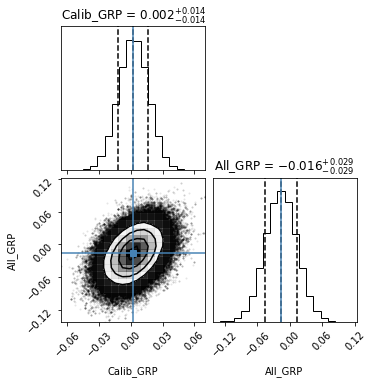

In [146]:
truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=["Calib_GRP", "All_GRP"], 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [147]:
npzName = "ALL_groups_ZP.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


In [148]:
mean = np.mean(NPZsamples[:,0])

mean

0.0022682002128622866

In [26]:
NPZsamples[:,0] -= mean

In [27]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))



theta

In [28]:
labs  = ['SNIa', 'FP', 'TFR', 'SBF_{main}', 'SBF_{ir}', 'SNII']

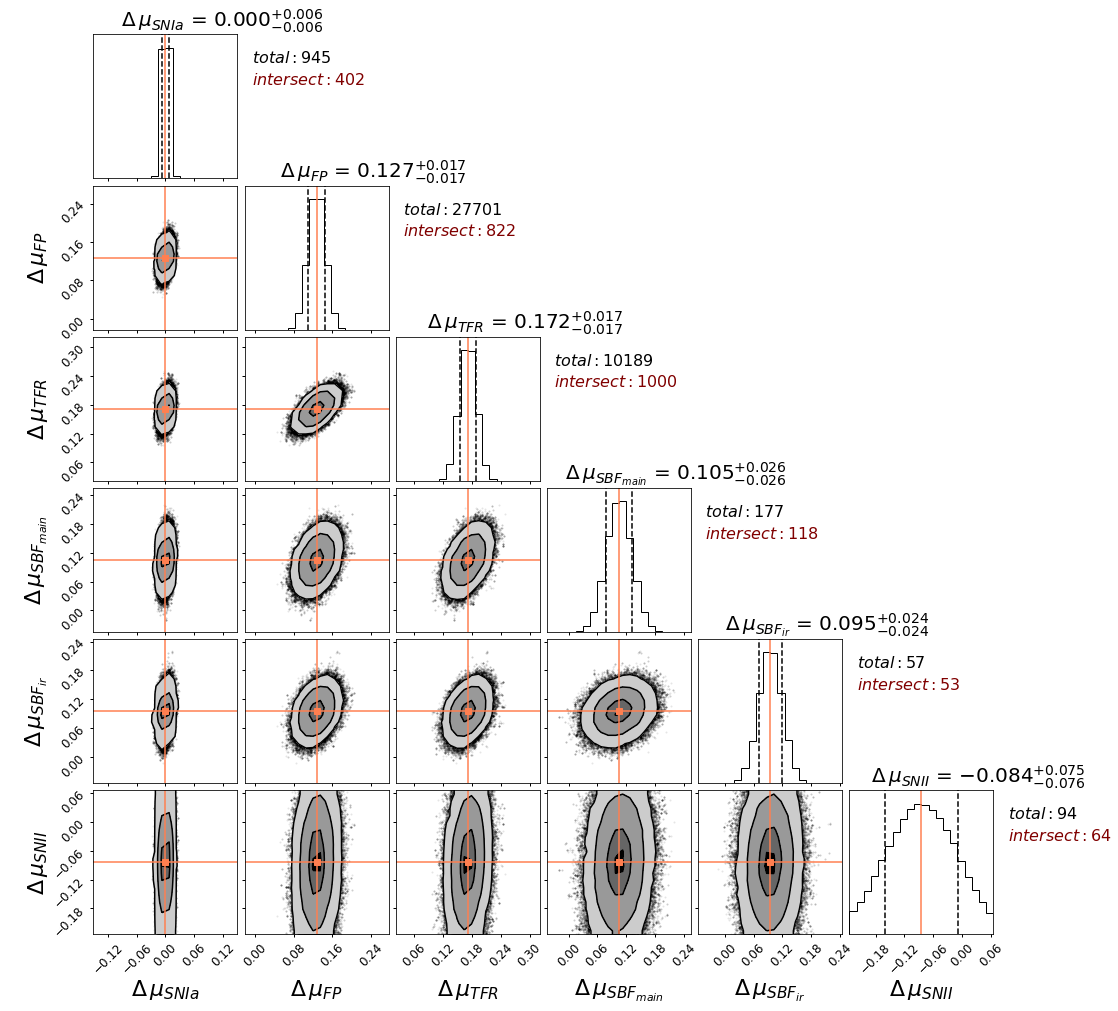

In [29]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
truths[0] = 0

labels = ['                  '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in labs] 

fig = corner.corner(NPZsamples, labels=labels, 
                    truths=truths, truth_color='coral',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 20}, 
                    title_fmt=".3f",
                    range=[(t-0.15,t+0.15) for t in truths]
                   )

m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

